# Load Dependencies

In [ ]:
!pip install planetary-computer
!pip install pystac-client
!pip install odc-stac
!pip install rasterio
!pip install rioxarray
!pip install matplotlib
!pip install pandas
!pip install scikit-learn

In [ ]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd
from geopy.distance import geodesic

# Geospatial operations
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

# Data Exploration on "Training_data_uhi_index.csv" dataset

In [ ]:
# Load the ground (basic) data from csv file
ground_df = pd.read_csv("/content/drive/MyDrive/EY Challenge 2025/Dataset/Training_data_uhi_index.csv")
ground_df

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634
...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245


*   Longitude: Geographic coordinate (X-axis)
*   Latitude: Geographic coordinate (Y-axis)
*   datetime: Timestamp of data collection (24-07-2021 HH:MM)
*   UHI Index: Target variable (heat intensity relative to the city’s average)

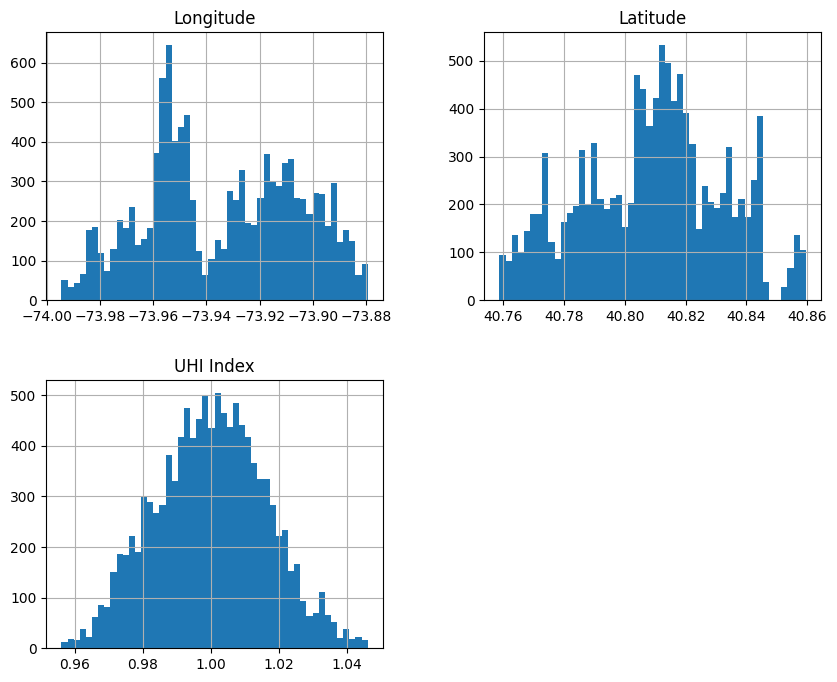

In [ ]:
# With the histogram below we can examine the distribution of each feature
ground_df.hist(bins=50, figsize=(10,8))
plt.show()

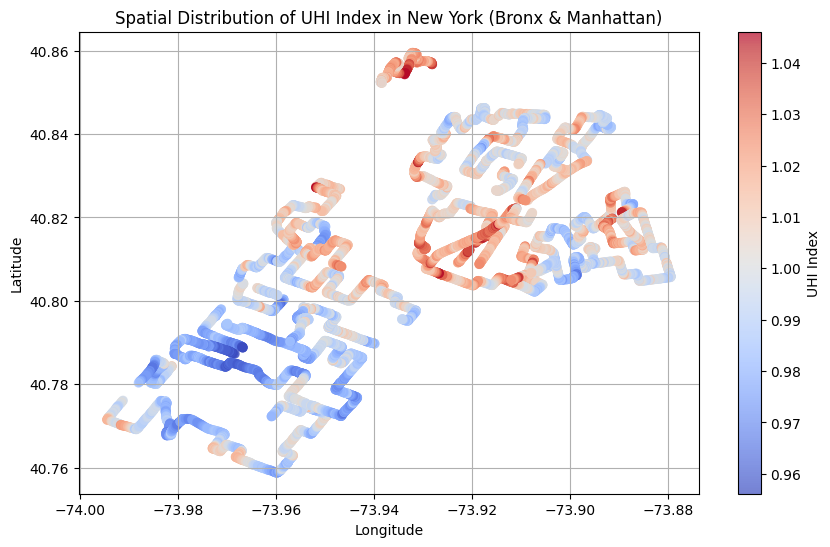

In [ ]:
# Scatter plot of UHI Index with geographical coordinates
plt.figure(figsize=(10, 6))
sc = plt.scatter(ground_df["Longitude"], ground_df["Latitude"], c=ground_df["UHI Index"], cmap="coolwarm", alpha=0.7)
plt.colorbar(sc, label="UHI Index")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of UHI Index in New York (Bronx & Manhattan)")
plt.grid(True)
plt.show()

# Data Exploration on "TNY_Mesonet_Weather.csv" dataset

In [ ]:
# Load the weather data
weather_data_path = "/content/drive/MyDrive/EY Challenge 2025/Dataset/NY_Mesonet_Weather.xlsx"
weather_data_bronx = pd.read_excel(weather_data_path, sheet_name=3)
weather_data_manhattan = pd.read_excel(weather_data_path, sheet_name=4)

Bronx station weather data

In [ ]:
weather_data_bronx

,Date / Time,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2]
0,2021-07-24 06:00:00 EDT,19.3,88.2,0.8,335,12
1,2021-07-24 06:05:00 EDT,19.4,87.9,0.8,329,18
2,2021-07-24 06:10:00 EDT,19.3,87.6,0.7,321,25
3,2021-07-24 06:15:00 EDT,19.4,87.4,0.5,307,33
4,2021-07-24 06:20:00 EDT,19.4,87.0,0.2,301,42
...,...,...,...,...,...,...
164,2021-07-24 19:40:00 EDT,24.9,49.0,3.5,184,24
165,2021-07-24 19:45:00 EDT,24.8,49.0,3.3,173,19
166,2021-07-24 19:50:00 EDT,24.9,48.7,3.8,168,17
167,2021-07-24 19:55:00 EDT,24.9,47.3,4.1,171,16


Manhattan station weather data

In [ ]:
weather_data_manhattan

,Date / Time,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2]
0,2021-07-24 06:00:00 EDT,21.3,66.5,0.9,348,10
1,2021-07-24 06:05:00 EDT,21.4,66.1,1.1,345,12
2,2021-07-24 06:10:00 EDT,21.4,66.5,1.3,4,14
3,2021-07-24 06:15:00 EDT,21.5,65.4,1.3,5,17
4,2021-07-24 06:20:00 EDT,21.5,65.0,1.5,346,19
...,...,...,...,...,...,...
164,2021-07-24 19:40:00 EDT,25.0,46.8,2.2,168,21
165,2021-07-24 19:45:00 EDT,24.9,47.3,3.0,167,18
166,2021-07-24 19:50:00 EDT,24.8,48.0,2.4,184,19
167,2021-07-24 19:55:00 EDT,24.8,48.0,2.0,182,18


In [ ]:
# Add a 'Station' column to differentiate the datasets
weather_data_bronx["Station"] = "Bronx"
weather_data_manhattan["Station"] = "Manhattan"

# Combine the Bronx and Manhattan weather data

In [ ]:
# Combine the two weather dataframes
weather_data = pd.concat([weather_data_bronx, weather_data_manhattan], ignore_index=True)
weather_data

,Date / Time,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],Station
0,2021-07-24 06:00:00 EDT,19.3,88.2,0.8,335,12,Bronx
1,2021-07-24 06:05:00 EDT,19.4,87.9,0.8,329,18,Bronx
2,2021-07-24 06:10:00 EDT,19.3,87.6,0.7,321,25,Bronx
3,2021-07-24 06:15:00 EDT,19.4,87.4,0.5,307,33,Bronx
4,2021-07-24 06:20:00 EDT,19.4,87.0,0.2,301,42,Bronx
...,...,...,...,...,...,...,...
333,2021-07-24 19:40:00 EDT,25.0,46.8,2.2,168,21,Manhattan
334,2021-07-24 19:45:00 EDT,24.9,47.3,3.0,167,18,Manhattan
335,2021-07-24 19:50:00 EDT,24.8,48.0,2.4,184,19,Manhattan
336,2021-07-24 19:55:00 EDT,24.8,48.0,2.0,182,18,Manhattan


In [ ]:
# Display basic statistics
print("Basic statistics")
print(weather_data.describe())

# Display basic info
print("\nBasic information")
print(weather_data.info())

# Display the number of missing values in each column
print("\nNumber of missing values in each column")
print(weather_data.isnull().sum())

Basic statistics
       Air Temp at Surface [degC]  Relative Humidity [percent]  \
count                  338.000000                   338.000000   
mean                    24.994083                    51.923669   
std                      2.195915                     9.741025   
min                     19.300000                    39.200000   
25%                     24.200000                    46.500000   
50%                     25.300000                    49.000000   
75%                     26.675000                    52.975000   
max                     28.400000                    88.200000   

       Avg Wind Speed [m/s]  Wind Direction [degrees]  Solar Flux [W/m^2]  
count            338.000000                338.000000          338.000000  
mean               2.140237                131.671598          383.934911  
std                0.940283                 89.351082          261.953450  
min                0.200000                  1.000000           10.000000  
25%     

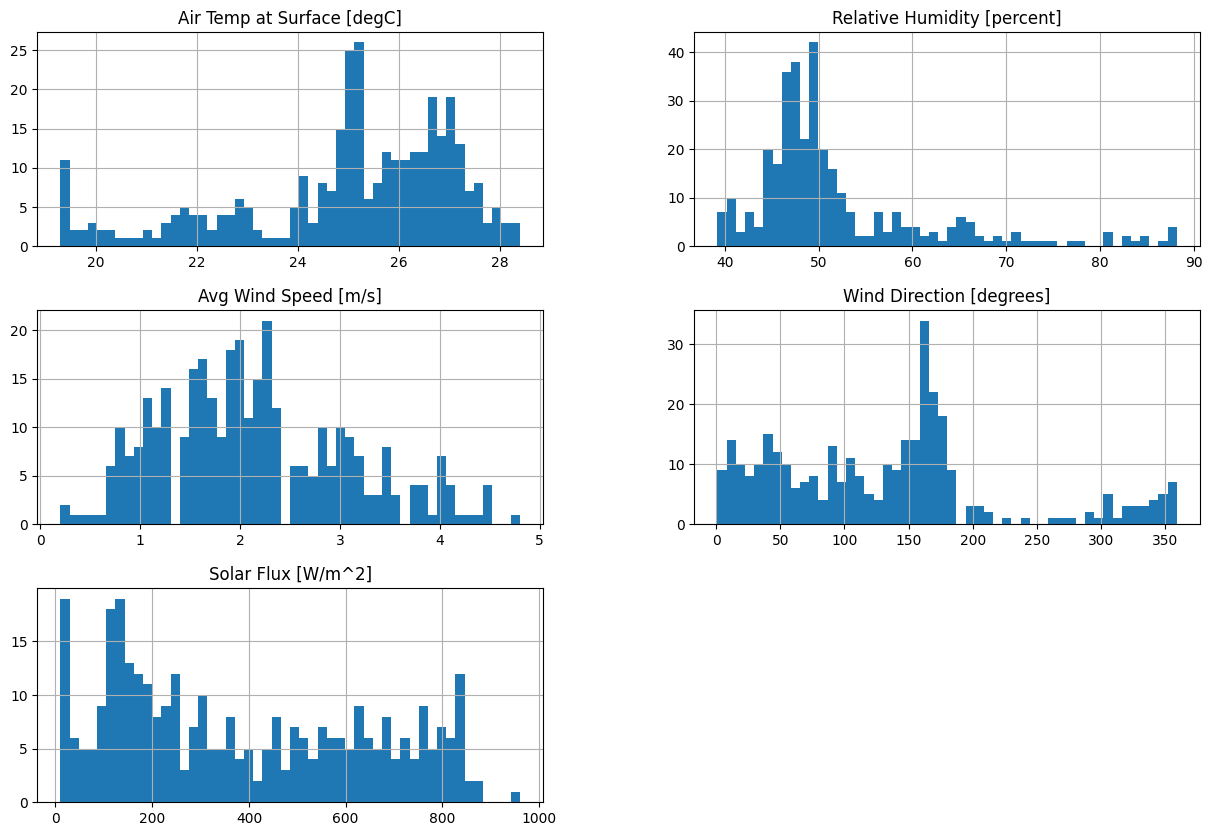

In [ ]:
weather_data.hist(bins=50, figsize=(15,10))
plt.show()

In [ ]:
weather_data.columns

Index(['Date / Time', 'Air Temp at Surface [degC]',
       'Relative Humidity [percent]', 'Avg Wind Speed [m/s]',
       'Wind Direction [degrees]', 'Solar Flux [W/m^2]', 'Station'],
      dtype='object')

In [ ]:
# Convert to datetime format and rename column to 'datetime'
weather_data['datetime'] = pd.to_datetime(weather_data['Date / Time'])
weather_data = weather_data.drop('Date / Time', axis=1)
weather_data

,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],Station,datetime
0,19.3,88.2,0.8,335,12,Bronx,2021-07-24 06:00:00
1,19.4,87.9,0.8,329,18,Bronx,2021-07-24 06:05:00
2,19.3,87.6,0.7,321,25,Bronx,2021-07-24 06:10:00
3,19.4,87.4,0.5,307,33,Bronx,2021-07-24 06:15:00
4,19.4,87.0,0.2,301,42,Bronx,2021-07-24 06:20:00
...,...,...,...,...,...,...,...
333,25.0,46.8,2.2,168,21,Manhattan,2021-07-24 19:40:00
334,24.9,47.3,3.0,167,18,Manhattan,2021-07-24 19:45:00
335,24.8,48.0,2.4,184,19,Manhattan,2021-07-24 19:50:00
336,24.8,48.0,2.0,182,18,Manhattan,2021-07-24 19:55:00


In [ ]:
# Match timestamps between the two datasets
# Convert timestamp to datetime format
ground_df['datetime'] = pd.to_datetime(ground_df['datetime'])

# Assign Each UHI Data Point to the Nearest Weather Station



*   Compute the distance from each UHI Index point to the Bronx and Manhattan weather stations.
*   Assign each UHI Index record to the nearest station (add new column: nearest_station)




In [ ]:
bronx_station = (40.87248, -73.89352)
manhattan_station = (40.76754, -73.96449)

In [ ]:
# Function to find the nearest station
def assign_nearest_station(row):
    uhi_point = (row['Latitude'], row['Longitude'])
    # Computes the distance between uhi_point to both stations using the geodesic distance
    distance_bronx = geodesic(uhi_point, bronx_station).kilometers
    distance_manhattan = geodesic(uhi_point, manhattan_station).kilometers
    if distance_bronx < distance_manhattan:
        return "Bronx"
    else:
        return "Manhattan"

In [ ]:
# Applying the function to each row of the dataFrame
ground_df['nearest_station'] = ground_df.apply(assign_nearest_station, axis=1)

In [ ]:
ground_df

,Longitude,Latitude,datetime,UHI Index,nearest_station
0,-73.909167,40.813107,2021-07-24 15:53:00,1.030289,Bronx
1,-73.909187,40.813045,2021-07-24 15:53:00,1.030289,Bronx
2,-73.909215,40.812978,2021-07-24 15:53:00,1.023798,Bronx
3,-73.909242,40.812908,2021-07-24 15:53:00,1.023798,Bronx
4,-73.909257,40.812845,2021-07-24 15:53:00,1.021634,Bronx
...,...,...,...,...,...
11224,-73.957050,40.790333,2021-07-24 15:57:00,0.972470,Manhattan
11225,-73.957063,40.790308,2021-07-24 15:57:00,0.972470,Manhattan
11226,-73.957093,40.790270,2021-07-24 15:57:00,0.981124,Manhattan
11227,-73.957112,40.790253,2021-07-24 15:59:00,0.981245,Manhattan


# Match Each UHI Data Point with the Closest Weather Timestamp


*   Weather data was recorded every 5 minutes
*   Identify the nearest 5-minute weather observation from the assigned station.



In [ ]:
# filter df on station
station_data = weather_data[weather_data['Station'] == 'Bronx']
station_data

,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],Station,datetime
0,19.3,88.2,0.8,335,12,Bronx,2021-07-24 06:00:00
1,19.4,87.9,0.8,329,18,Bronx,2021-07-24 06:05:00
2,19.3,87.6,0.7,321,25,Bronx,2021-07-24 06:10:00
3,19.4,87.4,0.5,307,33,Bronx,2021-07-24 06:15:00
4,19.4,87.0,0.2,301,42,Bronx,2021-07-24 06:20:00
...,...,...,...,...,...,...,...
164,24.9,49.0,3.5,184,24,Bronx,2021-07-24 19:40:00
165,24.8,49.0,3.3,173,19,Bronx,2021-07-24 19:45:00
166,24.9,48.7,3.8,168,17,Bronx,2021-07-24 19:50:00
167,24.9,47.3,4.1,171,16,Bronx,2021-07-24 19:55:00


In [ ]:
# Function to match UHI record with the closest weather timestamp from the assigned station
def find_closest_weather_timestamp(row):
    station = row['nearest_station']
    uhi_timestamp = row['datetime']

    # Filter weather data for the correct station
    station_data = weather_data[weather_data['Station'] == station]

    # Find the closest timestamp
    time_diffs = abs(station_data['datetime'] - uhi_timestamp)
    closest_index = time_diffs.idxmin()   # finds the index of the minimum time difference
    closest_timestamp = station_data.loc[closest_index, 'datetime']

    return closest_timestamp

In [ ]:
# Apply the function to each UHI data point
ground_df['closest_weather_timestamp'] = ground_df.apply(find_closest_weather_timestamp, axis=1)
ground_df

,Longitude,Latitude,datetime,UHI Index,nearest_station,closest_weather_timestamp
0,-73.909167,40.813107,2021-07-24 15:53:00,1.030289,Bronx,2021-07-24 15:55:00
1,-73.909187,40.813045,2021-07-24 15:53:00,1.030289,Bronx,2021-07-24 15:55:00
2,-73.909215,40.812978,2021-07-24 15:53:00,1.023798,Bronx,2021-07-24 15:55:00
3,-73.909242,40.812908,2021-07-24 15:53:00,1.023798,Bronx,2021-07-24 15:55:00
4,-73.909257,40.812845,2021-07-24 15:53:00,1.021634,Bronx,2021-07-24 15:55:00
...,...,...,...,...,...,...
11224,-73.957050,40.790333,2021-07-24 15:57:00,0.972470,Manhattan,2021-07-24 15:55:00
11225,-73.957063,40.790308,2021-07-24 15:57:00,0.972470,Manhattan,2021-07-24 15:55:00
11226,-73.957093,40.790270,2021-07-24 15:57:00,0.981124,Manhattan,2021-07-24 15:55:00
11227,-73.957112,40.790253,2021-07-24 15:59:00,0.981245,Manhattan,2021-07-24 16:00:00


In [ ]:
# Merge the datasets based on the closest weather timestamp and station
merged_df = pd.merge(ground_df, weather_data,  how='left', left_on=['closest_weather_timestamp', 'nearest_station'], right_on=['datetime', 'Station'])

In [ ]:
# Reset the index of the merged dataset
merged_df = merged_df.reset_index(drop=True)
merged_df

,Longitude,Latitude,datetime_x,UHI Index,nearest_station,closest_weather_timestamp,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],Station,datetime_y
0,-73.909167,40.813107,2021-07-24 15:53:00,1.030289,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621,Bronx,2021-07-24 15:55:00
1,-73.909187,40.813045,2021-07-24 15:53:00,1.030289,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621,Bronx,2021-07-24 15:55:00
2,-73.909215,40.812978,2021-07-24 15:53:00,1.023798,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621,Bronx,2021-07-24 15:55:00
3,-73.909242,40.812908,2021-07-24 15:53:00,1.023798,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621,Bronx,2021-07-24 15:55:00
4,-73.909257,40.812845,2021-07-24 15:53:00,1.021634,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621,Bronx,2021-07-24 15:55:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,-73.957050,40.790333,2021-07-24 15:57:00,0.972470,Manhattan,2021-07-24 15:55:00,26.8,46.7,3.4,196,605,Manhattan,2021-07-24 15:55:00
11225,-73.957063,40.790308,2021-07-24 15:57:00,0.972470,Manhattan,2021-07-24 15:55:00,26.8,46.7,3.4,196,605,Manhattan,2021-07-24 15:55:00
11226,-73.957093,40.790270,2021-07-24 15:57:00,0.981124,Manhattan,2021-07-24 15:55:00,26.8,46.7,3.4,196,605,Manhattan,2021-07-24 15:55:00
11227,-73.957112,40.790253,2021-07-24 15:59:00,0.981245,Manhattan,2021-07-24 16:00:00,27.0,46.1,2.7,209,620,Manhattan,2021-07-24 16:00:00


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Longitude                    11229 non-null  float64       
 1   Latitude                     11229 non-null  float64       
 2   datetime_x                   11229 non-null  datetime64[ns]
 3   UHI Index                    11229 non-null  float64       
 4   nearest_station              11229 non-null  object        
 5   closest_weather_timestamp    11229 non-null  datetime64[ns]
 6   Air Temp at Surface [degC]   11229 non-null  float64       
 7   Relative Humidity [percent]  11229 non-null  float64       
 8   Avg Wind Speed [m/s]         11229 non-null  float64       
 9   Wind Direction [degrees]     11229 non-null  int64         
 10  Solar Flux [W/m^2]           11229 non-null  int64         
 11  Station                      11229 non-nu

In [ ]:
# Display basic statistics
print("Basic statistics")
print(merged_df.describe())

# Display basic info
print("\nBasic information")
print(merged_df.info())

# Display the number of missing values in each column
print("\nNumber of missing values in each column")
print(merged_df.isnull().sum())

Basic statistics
          Longitude      Latitude                     datetime_x  \
count  11229.000000  11229.000000                          11229   
mean     -73.933927     40.808800  2021-07-24 15:34:29.056906240   
min      -73.994457     40.758792            2021-07-24 15:01:00   
25%      -73.955703     40.790905            2021-07-24 15:22:00   
50%      -73.932968     40.810688            2021-07-24 15:36:00   
75%      -73.909647     40.824515            2021-07-24 15:48:00   
max      -73.879458     40.859497            2021-07-24 15:59:00   
std        0.028253      0.023171                            NaN   

          UHI Index      closest_weather_timestamp  \
count  11229.000000                          11229   
mean       1.000001  2021-07-24 15:34:27.085225728   
min        0.956122            2021-07-24 15:00:00   
25%        0.988577            2021-07-24 15:20:00   
50%        1.000237            2021-07-24 15:35:00   
75%        1.011176            2021-07-24 15:5

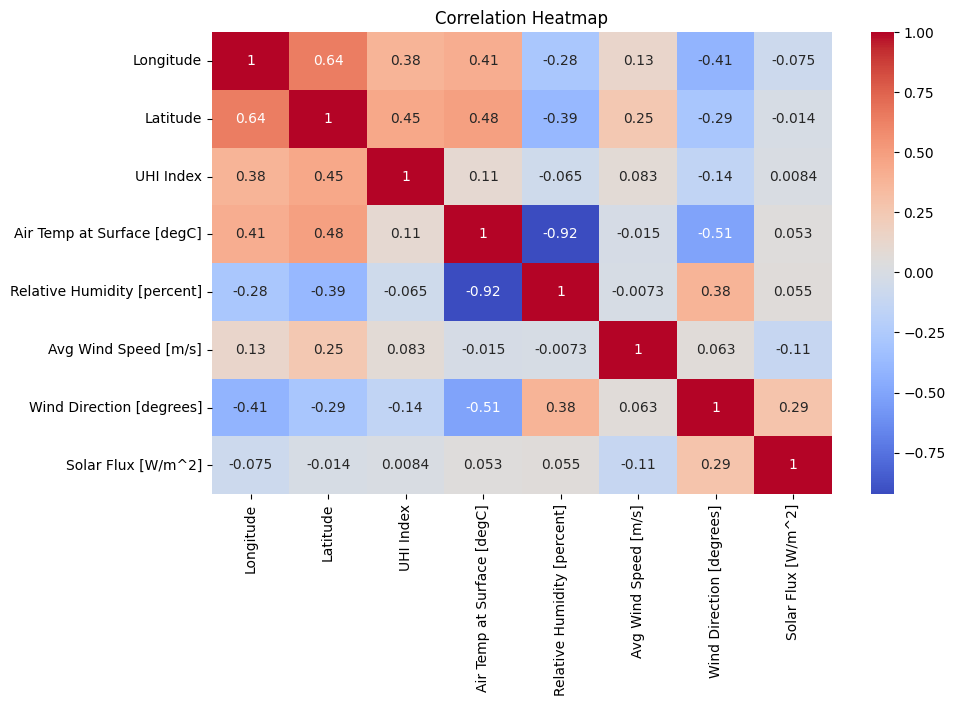

In [ ]:
# Display the correlation between different features in the dataset

# Create a new DataFrame with only numerical features
numerical_df = merged_df.drop(columns=['datetime_x', 'datetime_y', 'closest_weather_timestamp', 'nearest_station', 'Station'])

plt.figure(figsize=(10, 6))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Reset the index of the merged dataset
merged_df = merged_df.reset_index(drop=True)
merged_df

,Longitude,Latitude,datetime_x,UHI Index,nearest_station,closest_weather_timestamp,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],Station,datetime_y
0,-73.909167,40.813107,2021-07-24 15:53:00,1.030289,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621,Bronx,2021-07-24 15:55:00
1,-73.909187,40.813045,2021-07-24 15:53:00,1.030289,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621,Bronx,2021-07-24 15:55:00
2,-73.909215,40.812978,2021-07-24 15:53:00,1.023798,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621,Bronx,2021-07-24 15:55:00
3,-73.909242,40.812908,2021-07-24 15:53:00,1.023798,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621,Bronx,2021-07-24 15:55:00
4,-73.909257,40.812845,2021-07-24 15:53:00,1.021634,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621,Bronx,2021-07-24 15:55:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,-73.957050,40.790333,2021-07-24 15:57:00,0.972470,Manhattan,2021-07-24 15:55:00,26.8,46.7,3.4,196,605,Manhattan,2021-07-24 15:55:00
11225,-73.957063,40.790308,2021-07-24 15:57:00,0.972470,Manhattan,2021-07-24 15:55:00,26.8,46.7,3.4,196,605,Manhattan,2021-07-24 15:55:00
11226,-73.957093,40.790270,2021-07-24 15:57:00,0.981124,Manhattan,2021-07-24 15:55:00,26.8,46.7,3.4,196,605,Manhattan,2021-07-24 15:55:00
11227,-73.957112,40.790253,2021-07-24 15:59:00,0.981245,Manhattan,2021-07-24 16:00:00,27.0,46.1,2.7,209,620,Manhattan,2021-07-24 16:00:00


In [ ]:
merged_df = merged_df.drop(columns=['datetime_x', 'datetime_y', 'closest_weather_timestamp', 'nearest_station', 'Station'])

In [ ]:
# Reset the index of the merged dataset
merged_df = merged_df.reset_index(drop=True)
merged_df

,Longitude,Latitude,UHI Index,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2]
0,-73.909167,40.813107,1.030289,27.2,47.3,2.6,165,621
1,-73.909187,40.813045,1.030289,27.2,47.3,2.6,165,621
2,-73.909215,40.812978,1.023798,27.2,47.3,2.6,165,621
3,-73.909242,40.812908,1.023798,27.2,47.3,2.6,165,621
4,-73.909257,40.812845,1.021634,27.2,47.3,2.6,165,621
...,...,...,...,...,...,...,...,...
11224,-73.957050,40.790333,0.972470,26.8,46.7,3.4,196,605
11225,-73.957063,40.790308,0.972470,26.8,46.7,3.4,196,605
11226,-73.957093,40.790270,0.981124,26.8,46.7,3.4,196,605
11227,-73.957112,40.790253,0.981245,27.0,46.1,2.7,209,620


In [ ]:
# merged_df.to_csv('/content/drive/MyDrive/EY Challenge 2025/Dataset/merged_weather_data.csv', index=False)

# Feature Engineering on Weather Data

 Heat Index (Perceived Temperature)

 The apparent temperature that a human perceives, based on air temperature and humidity.

In [ ]:
# calculate the Heat Index (Perceived Temperature)

def calculate_heat_index(temperature, humidity):
  """
  Calculates the Heat Index (perceived temperature) based on temperature and relative humidity.

  Args:
      temperature (float): Temperature in Fahrenheit.
      humidity (float): Relative humidity as a percentage.

  Returns:
      float: The calculated Heat Index in Fahrenheit.
  """
  c1 = -42.379
  c2 = 2.04901523
  c3 = 10.14333127
  c4 = -0.22475541
  c5 = -6.83783e-3
  c6 = -5.481717e-2
  c7 = 1.22874e-3
  c8 = 8.5282e-4
  c9 = -1.99e-6

  if temperature >= 80 and humidity >= 40:
    # Use National Weather Service (NWS) formula to calculate heat index
    heat_index = (
      c1
      + (c2 * temperature)
      + (c3 * humidity)
      + (c4 * temperature * humidity)
      + (c5 * temperature**2)
      + (c6 * humidity**2)
      + (c7 * temperature**2 * humidity)
      + (c8 * temperature * humidity**2)
      + (c9 * temperature**2 * humidity**2)
  )
  else:
    # Use the Simplified Linear Approximation for lower values
    heat_index = 0.5 * (temperature + 61.0 + ((temperature - 68.0) * 1.2) + (humidity * 0.094))

  return heat_index


In [ ]:
# Convert temperature from Celsius to Fahrenheit
merged_df['Air Temperature (F)'] = (merged_df['Air Temp at Surface [degC]'] * 9/5) + 32

# Apply the heat index function
merged_df["Heat Index (F)"] = merged_df.apply(lambda row: calculate_heat_index(row["Air Temperature (F)"], row["Relative Humidity [percent]"]), axis=1)

# Convert Heat Index back to Celsius
merged_df["Heat Index (C)"] = (merged_df["Heat Index (F)"] - 32) * 5/9

# Drop intermediate Fahrenheit columns if not needed
merged_df.drop(columns=["Air Temperature (F)", "Heat Index (F)"], inplace=True)

Wind Cooling Effect

The Wind Cooling Effect estimates how wind influences temperature dispersion by combining wind speed and direction. Wind blowing directly towards a location maximizes cooling, while wind at an angle has a reduced effect, scaled by the cosine of the angle.

In [ ]:
# Calculate Wind Cooling Effect
merged_df["Wind_Cooling_Effect"] = merged_df["Avg Wind Speed [m/s]"] * np.cos(np.radians(merged_df["Wind Direction [degrees]"]))

In [ ]:
merged_df["Wind_Cooling_Effect"] = (merged_df["Wind_Cooling_Effect"] - merged_df["Wind_Cooling_Effect"].min()) / \
                                   (merged_df["Wind_Cooling_Effect"].max() - merged_df["Wind_Cooling_Effect"].min())


In [ ]:
merged_df

,Longitude,Latitude,UHI Index,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],Heat Index (C),Wind_Cooling_Effect
0,-73.909167,40.813107,1.030289,27.2,47.3,2.6,165,621,27.434996,0.438306
1,-73.909187,40.813045,1.030289,27.2,47.3,2.6,165,621,27.434996,0.438306
2,-73.909215,40.812978,1.023798,27.2,47.3,2.6,165,621,27.434996,0.438306
3,-73.909242,40.812908,1.023798,27.2,47.3,2.6,165,621,27.434996,0.438306
4,-73.909257,40.812845,1.021634,27.2,47.3,2.6,165,621,27.434996,0.438306
...,...,...,...,...,...,...,...,...,...,...
11224,-73.957050,40.790333,0.972470,26.8,46.7,3.4,196,605,27.053202,0.265542
11225,-73.957063,40.790308,0.972470,26.8,46.7,3.4,196,605,27.053202,0.265542
11226,-73.957093,40.790270,0.981124,26.8,46.7,3.4,196,605,27.053202,0.265542
11227,-73.957112,40.790253,0.981245,27.0,46.1,2.7,209,620,27.187914,0.472529


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Longitude                    11229 non-null  float64       
 1   Latitude                     11229 non-null  float64       
 2   datetime_x                   11229 non-null  datetime64[ns]
 3   UHI Index                    11229 non-null  float64       
 4   nearest_station              11229 non-null  object        
 5   closest_weather_timestamp    11229 non-null  datetime64[ns]
 6   Air Temp at Surface [degC]   11229 non-null  float64       
 7   Relative Humidity [percent]  11229 non-null  float64       
 8   Avg Wind Speed [m/s]         11229 non-null  float64       
 9   Wind Direction [degrees]     11229 non-null  int64         
 10  Solar Flux [W/m^2]           11229 non-null  int64         
 11  Station                      11229 non-nu

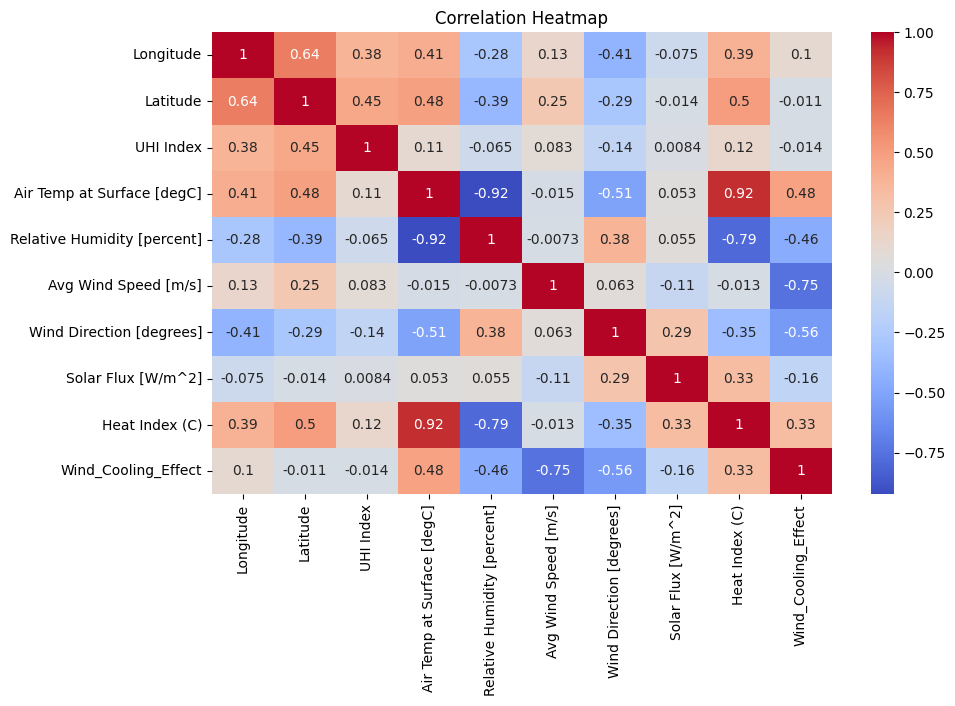

In [ ]:
# Display the correlation between different features in the dataset
# Create a new DataFrame with only numerical features
# numerical_df = merged_df.drop(columns=['datetime_x', 'datetime_y', 'closest_weather_timestamp', 'nearest_station', 'Station'])

plt.figure(figsize=(10, 6))
sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
merged_df.to_csv('/content/drive/MyDrive/EY Challenge 2025/Dataset/merged_weather_data.csv', index=False)

# Basic RF Model Building


In [ ]:
merged_df.columns

Index(['Longitude', 'Latitude', 'datetime_x', 'UHI Index', 'nearest_station',
       'closest_weather_timestamp', 'Air Temp at Surface [degC]',
       'Relative Humidity [percent]', 'Avg Wind Speed [m/s]',
       'Wind Direction [degrees]', 'Solar Flux [W/m^2]', 'Station',
       'datetime_y', 'Heat Index (C)'],
      dtype='object')

In [ ]:
# Select feature columns
X = merged_df[['Air Temp at Surface [degC]', 'Relative Humidity [percent]', 'Avg Wind Speed [m/s]', 'Wind Direction [degrees]', 'Solar Flux [W/m^2]']]
# Select the target value
y = merged_df['UHI Index']

In [ ]:
# transform and reshape the X,y to np arrays
X = np.array(X).reshape(-1, 5)
y = np.array(y)

In [ ]:
# Split the data to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the training and testing data and transform it
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Create and train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R-squared score: {r2}")

R-squared score: 0.13484021792553857


In [ ]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R-squared score: {r2}")

R-squared score: 0.13484021792553813


In [ ]:
# Make predictions on the entire dataset
# X_all = merged_df[['Air Temp at Surface [degC]', 'Relative Humidity [percent]', 'Avg Wind Speed [m/s]', 'Wind Direction [degrees]', 'Solar Flux [W/m^2]']]
# X_all = np.array(X_all).reshape(-1, 5)
# X_all_scaled = scaler.transform(X_all)



# Create a submission DataFrame
submission_df = pd.DataFrame({
    'Longitude': merged_df['Longitude'],
    'Latitude': merged_df['Latitude'],
    'UHI Index': y_pred
})

# Display the first few rows of the submission dataframe
print(submission_df.head())

# Export the submission file to a CSV file
submission_df.to_csv('/content/drive/MyDrive/EY Challenge 2025/Dataset/test_submission.csv', index=False)

   Longitude   Latitude  UHI Index
0 -73.909167  40.813107    1.00091
1 -73.909187  40.813045    1.00091
2 -73.909215  40.812978    1.00091
3 -73.909242  40.812908    1.00091
4 -73.909257  40.812845    1.00091


In [ ]:
submission_df

,Longitude,Latitude,Predicted UHI Index
0,-73.909167,40.813107,1.000910
1,-73.909187,40.813045,1.000910
2,-73.909215,40.812978,1.000910
3,-73.909242,40.812908,1.000910
4,-73.909257,40.812845,1.000910
...,...,...,...
11224,-73.957050,40.790333,0.998290
11225,-73.957063,40.790308,0.998290
11226,-73.957093,40.790270,0.998290
11227,-73.957112,40.790253,0.998151
